# Auto Encoder for LCH Olympics

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from sklearn import metrics
import numpy as np
import colorsys
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import pandas as pd
#from pyjet import cluster,DTYPE_PTEPM
import random
import math


/tmpscratch/ktamenar/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()
device

'cuda:0'

In [3]:
torch.cuda.set_device(device)
torch.cuda.empty_cache()

In [4]:
events= pd.read_hdf('events_rotate.h5')
print(np.shape(events))
events.head(5)

(1000000, 477)


,0,1,2,3,4,5,6,7,8,9,...,467,468,469,470,471,472,473,474,475,476
0,160.280,-0.775630,4.80196,147.447,-0.761960,4.79742,145.1770,-0.761662,4.79270,94.9798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,199.078,0.314598,1.77951,156.365,0.420856,1.45046,141.0500,0.347907,1.43924,101.6660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,387.967,-1.057200,1.55025,264.843,-1.047750,1.53265,255.9740,-1.049300,1.55188,229.6310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,261.120,-0.242184,1.30457,210.262,-0.234154,1.34119,102.8820,-0.241660,1.35433,93.4942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,263.943,-0.003251,4.77306,186.349,-0.002712,4.77400,86.6281,-0.667637,4.87068,80.5108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
events_re = events.values.reshape(159000000,3)
np.shape(events_re)
events_re = pd.DataFrame(events_re, columns = ["pT","eta","phi"])

# Map phi from [0,2Pi] -> [-Pi,Pi]

events_re["phi"] = np.where(events_re["phi"] > math.pi, events_re["phi"] - 2*math.pi, events_re["phi"])

print("pT max = {}, min = {} ".format (events_re["pT"].max(), events_re["pT"].min()))
print("eta max = {}, min = {} ".format (events_re["eta"].max(), events_re["eta"].min()))
print("phi max = {}, min = {} ".format (events_re["phi"].max(), events_re["phi"].min()))


pT max = 3459.44, min = 0.0 
eta max = 2.97343, min = -3.12334 
phi max = 2.72477, min = -2.7364253071795863 


In [6]:
#Data Normalization [0,1]

#events_re["pT"] = events_re["pT"]/events_re["pT"].max()
#events_re["eta"] = (events_re["eta"] - events_re["eta"].min())/(events_re["eta"].max() - events_re["eta"].min())
#events_re["phi"] = (events_re["phi"] - events_re["phi"].min())/(events_re["phi"].max() - events_re["phi"].min())

#Data Normalization [-1,1] for all elements

events_re["pT"] = events_re["pT"]/events_re["pT"].max()
events_re["eta"] = events_re["eta"] / events_re["eta"].max()
events_re["phi"] = events_re["phi"] / events_re["phi"].max() 

events_re.head(-5)

,pT,eta,phi
0,0.046331,-0.260854,-0.543615
1,0.042622,-0.256256,-0.545281
2,0.041965,-0.256156,-0.547013
3,0.027455,-0.257499,-0.546397
4,0.018350,-0.260073,-0.540037
...,...,...,...
158999990,0.000000,0.000000,0.000000
158999991,0.000000,0.000000,0.000000
158999992,0.000000,0.000000,0.000000
158999993,0.000000,0.000000,0.000000


In [7]:
print("pT max = {}, min = {} ".format (events_re["pT"].max(), events_re["pT"].min()))
print("eta max = {}, min = {:.2f} ".format (events_re["eta"].max(), events_re["eta"].min()))
print("phi max = {}, min = {:.2f} ".format (events_re["phi"].max(), events_re["phi"].min()))

pT max = 1.0, min = 0.0 
eta max = 1.0, min = -1.05 
phi max = 1.0, min = -1.00 


In [8]:
# Reshape and separates de events into test, validation and training

events = events_re.values.reshape(1000000,477) 

events_tra, events_val, events_tes = np.split(events, [int(.6*len(events)), int(.8*len(events))])

print(len(events_tra))
print(len(events_val))
print(len(events_tes))

600000
200000
200000


In [9]:
#Autoencoder example 

class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        # encoder
        
        n1, n2, n3, n4, n5, n6 = 477, 350, 200, 100, 50, 16
        
        self.enc1 = nn.Linear(in_features= n1, out_features=n2)
        self.enc2 = nn.Linear(in_features=n2, out_features=n3)
        self.enc3 = nn.Linear(in_features=n3, out_features=n4)
        self.enc4 = nn.Linear(in_features=n4, out_features=n5)
        self.enc5 = nn.Linear(in_features=n5, out_features=n6)
        # decoder 
        self.dec1 = nn.Linear(in_features=n6, out_features=n5)
        self.dec2 = nn.Linear(in_features=n5, out_features=n4)
        self.dec3 = nn.Linear(in_features=n4, out_features=n3)
        self.dec4 = nn.Linear(in_features=n3, out_features=n2)
        self.dec5 = nn.Linear(in_features=n2, out_features= n1)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = self.dec5(x)
        return x
model = Autoencoder1()
#print(model)

In [10]:
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(),
        lr = 1e-3,
        weight_decay = 1e-8)

criterion = nn.MSELoss()

epochs = 50
batch_size = 128


#Events for training set

#trainset = torch.tensor(events_tra.values)
trainset = torch.tensor(events_tra)
trainset=trainset.to(torch.float32)
#print(trainset.shape)


trainloader = DataLoader(
    dataset=trainset, 
    batch_size=batch_size,
    shuffle=True,
)
print(trainloader)
print(len(trainloader))

print("******************************")

#Events for validation set

#valset = torch.tensor(events_val.values)
valset = torch.tensor(events_val)
valset=valset.to(torch.float32)

valloader = DataLoader(
    dataset = valset, 
    batch_size = batch_size,
    shuffle = True,
)

print(valloader)
print(len(valloader))
print("********************************")
type(trainloader.dataset)
type(valloader.dataset)

4688
******************************
1563
********************************


torch.Tensor

In [11]:
yv, xv, xt, yt, train_losses,val_losses = [],[],[],[],[],[]

def train(epoch):
    model.train()
    train_loss, val_loss = 0, 0
    #total_squared_error, total_squared_error_val = 0 ,0 
    #total_samples, total_samples_val = 0, 0
    
    for data in trainloader:
        optimizer.zero_grad()
        data = data.cuda() #input and target data 
        xt.append(data.cpu().detach().numpy())         
        y=model(data)  #output
        yt.append(y.cpu().detach().numpy())
        loss = criterion(y, data) #comparision between input and target data(output)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    
    print('====> Epoch: {} Average_training_loss: {:.6f}'.format(
        epoch, train_loss / len(trainloader)))
    
    train_losses.append(train_loss / len(trainloader))
 
    model.eval()
    for data in valloader:
        optimizer.zero_grad()
        data = data.cuda()
        xv.append(data.cpu().detach().numpy())
        y=model(data)
        yv.append(y.cpu().detach().numpy())
        loss = criterion(y, data)
        loss.backward()
        val_loss += loss.item()
        optimizer.step()
    
    print('====> Epoch: {} Average_validation_loss: {:.6f}'.format(
        epoch, val_loss / len(valloader)))
    
    val_losses.append(val_loss / len(valloader))
    
    print('*********************************************************')


In [12]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 1 Average_training_loss: 0.002796
====> Epoch: 1 Average_validation_loss: 0.001340
*********************************************************
====> Epoch: 2 Average_training_loss: 0.001155
====> Epoch: 2 Average_validation_loss: 0.001031
*********************************************************
====> Epoch: 3 Average_training_loss: 0.000964
====> Epoch: 3 Average_validation_loss: 0.000917
*********************************************************
====> Epoch: 4 Average_training_loss: 0.000875
====> Epoch: 4 Average_validation_loss: 0.000840
*********************************************************
====> Epoch: 5 Average_training_loss: 0.000814
====> Epoch: 5 Average_validation_loss: 0.000786
*********************************************************
====> Epoch: 6 Average_training_loss: 0.000769
====> Epoch: 6 Average_validation_loss: 0.000746
*********************************************************
====> Epoch: 7 Average_training_loss: 0.000732
====> Epoch: 7 Average_valida

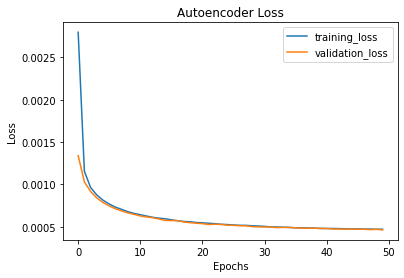

In [13]:
# Loss plot

plt.figure()
plt.plot(train_losses, alpha=1.0, linewidth=1.5, label="training_loss")
plt.plot(val_losses, alpha=1.0, linewidth=1.5, label="validation_loss")
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.legend(loc='upper right')
plt.savefig('Loss.png')

#fig.tight_layout()
#fig.savefig( "Loss.png", bbox_inches='tight' )

# Visualizing input vs output

In [14]:
def plot_heatmap(input, output, label):

    input = input.reshape(159,3)
    output = output.reshape(159,3)

    input = pd.DataFrame(input, columns = ["pT","eta","phi"])
    input = input.loc[~(input==0).all(axis=1)]
    output = pd.DataFrame(output, columns = ["pT","eta","phi"])
    output = output.loc[~(output==0).all(axis=1)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    surf = ax.bar3d(input['phi'],input['eta'],input['pT'],0.05,0.05,0.05,color='g',shade=True)
    in_proxy = plt.Rectangle((0, 0), 1, 1, fc="g")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("phi")
    ax.set_ylabel("eta")
    ax.set_zlabel("pT")
    surf2 = ax.bar3d(output['phi'],output['eta'],output['pT'],0.05,0.05,0.05,shade=True)
    out_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
    ax.legend([in_proxy,out_proxy],['input event','AE output event'])
    plt.show()
    plt.close()

In [15]:
def plot_heatmap_blue(input, output, label):

    input = input.reshape(159,3)
    output = output.reshape(159,3)

    input = pd.DataFrame(input, columns = ["pT","eta","phi"])
    input = input.loc[~(input==0).all(axis=1)]
    output = pd.DataFrame(output, columns = ["pT","eta","phi"])
    output = output.loc[~(output==0).all(axis=1)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    #surf = ax.bar3d(input['eta'],input['phi'],5,0.2,0.2,input['pT'],color='g',shade=True)
    in_proxy = plt.Rectangle((0, 0), 1, 1, fc="g")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("phi")
    ax.set_ylabel("eta")
    ax.set_zlabel("pT")
    surf2 = ax.bar3d(output['phi'],output['eta'],output['pT'],0.05,0.05,0.05,shade=True)
    out_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
    ax.legend([in_proxy,out_proxy],['input event','AE output event'])
    plt.show()
    plt.close()

In [16]:
def plot_heatmap_green(input, output, label):

    input = input.reshape(159,3)
    output = output.reshape(159,3)

    input = pd.DataFrame(input, columns = ["pT","eta","phi"])
    input = input.loc[~(input==0).all(axis=1)]
    output = pd.DataFrame(output, columns = ["pT","eta","phi"])
    output = output.loc[~(output==0).all(axis=1)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    surf = ax.bar3d(input['phi'],input['eta'],input['pT'],0.05,0.05,0.05,color='g',shade=True)
    in_proxy = plt.Rectangle((0, 0), 1, 1, fc="g")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("phi")
    ax.set_ylabel("eta")
    ax.set_zlabel("pT")
    #surf2 = ax.bar3d(output['eta'],output['phi'],5,0.2,0.2,output['pT'],shade=True)
    out_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
    ax.legend([in_proxy,out_proxy],['input event','AE output event'])
    plt.show()
    plt.close()

In [17]:
n=1234
yn = yt[n]
print(yn.shape)
xn = xt[n]
print(xn.shape)

(128, 477)
(128, 477)


In [18]:
xn
print(yn)

[[ 9.0062171e-02 -2.4311566e-01 -4.7645140e-01 ... -1.6471744e-04
   1.6901805e-04 -4.2375531e-03]
 [ 1.6746661e-01 -1.4833716e-01  5.1803362e-01 ...  2.5119623e-03
  -5.6259092e-03 -3.8448665e-03]
 [ 5.8395322e-02  1.4203915e-01 -5.6329697e-01 ... -2.9214653e-03
   7.2427690e-03 -1.7342279e-02]
 ...
 [ 2.2130549e-01 -1.7457474e-02  6.8624848e-01 ... -3.5607861e-03
   1.1668939e-03 -6.0181338e-03]
 [ 8.6393028e-02 -3.0459499e-01 -4.6236297e-01 ...  2.4229651e-03
   3.1738130e-03 -7.4288007e-03]
 [ 6.1708473e-02 -1.9573927e-01 -5.3147376e-01 ...  7.5929426e-03
   5.9584226e-04 -1.3827328e-03]]


/srv/ipykernel_90/1341437756.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


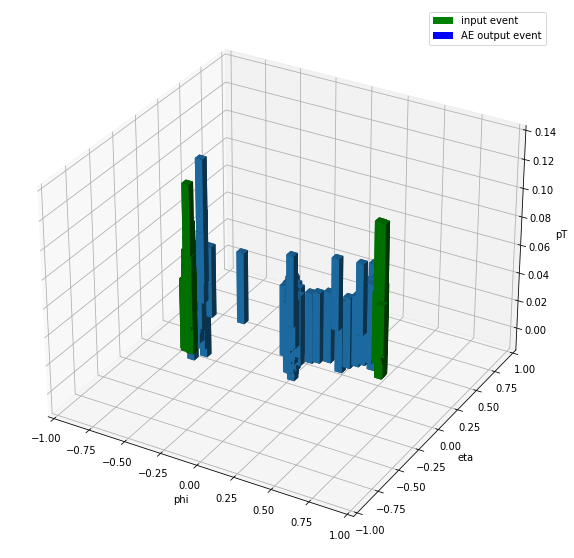

In [19]:
plot_heatmap(xn[0],yn[0],"all")

/srv/ipykernel_90/3785642609.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


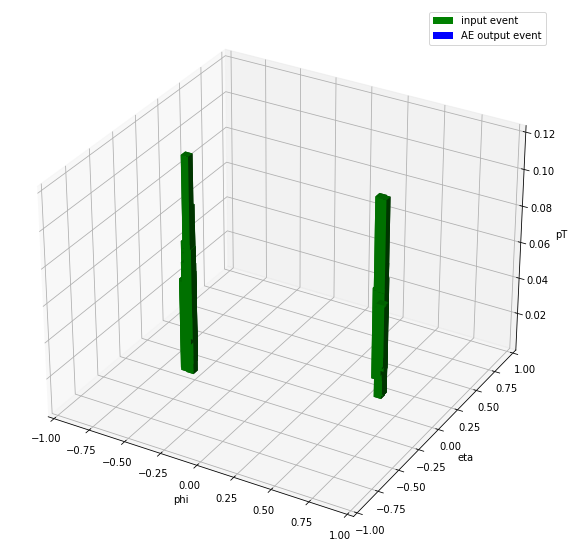

In [20]:
plot_heatmap_green(xn[0],yn[0],"green")

/srv/ipykernel_90/83623408.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


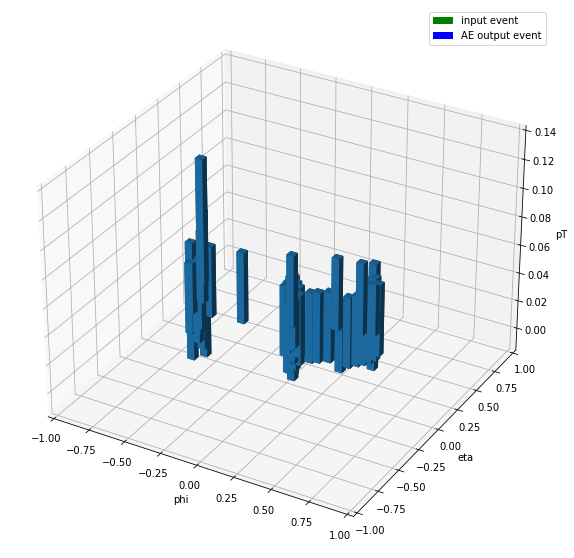

In [21]:
plot_heatmap_blue(xn[0],yn[0],"blue")

In [22]:
#yn goes from 1-batch size

n=10
yns = yn[n].reshape(159,3) 
print(yns.shape)
xns = xn[n].reshape(159,3)
print(xns.shape)
xns= pd.DataFrame(xns, columns=["pT","eta","phi"])
yns= pd.DataFrame(yns, columns=["pT","eta","phi"])

(159, 3)
(159, 3)


Text(0, 0.5, 'output')

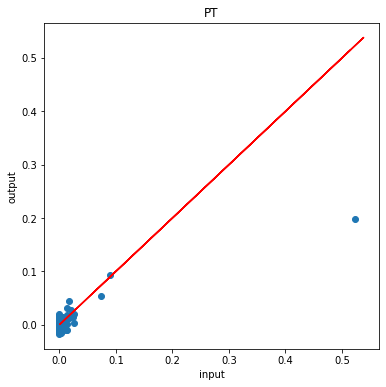

In [23]:
diag= np.random.uniform(low=0, high=xns["pT"].max()+.015, size=(500,))
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xns["pT"],yns["pT"])
plt.plot(diag,diag, color="red")
plt.title("PT")
plt.xlabel("input")
plt.ylabel("output")
#ax.plot(ident,ident)

Text(0, 0.5, 'output')

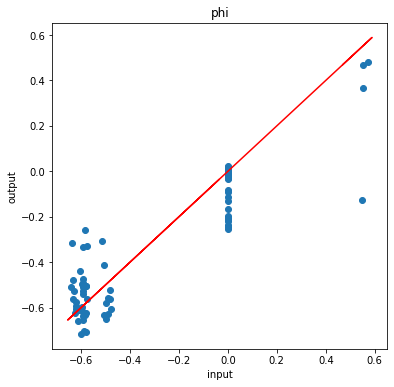

In [24]:
diag= np.random.uniform(low=xns["phi"].min()-.015, high=xns["phi"].max()+.015, size=(500,))
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xns["phi"],yns["phi"])
plt.plot(diag,diag, color="red")
plt.title("phi")
plt.xlabel("input")
plt.ylabel("output")

Text(0, 0.5, 'output')

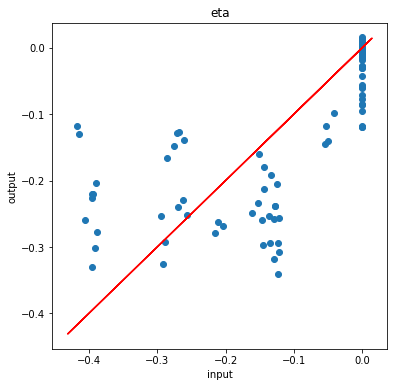

In [25]:
diag= np.random.uniform(low=xns["eta"].min()-.015, high=xns["eta"].max()+.015, size=(500,))
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xns["eta"],yns["eta"])
plt.plot(diag,diag, color="red")
plt.title("eta")
plt.xlabel("input")
plt.ylabel("output")